In [ ]:
! pip install chembl_webresource_client
! pip install lazypredict
! pip install jcopml==1.1.1

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
#from jcopml.plot import plot_missing_value

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors, Lipinski

import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import lazypredict
from lazypredict.Supervised import LazyRegressor, LazyClassifier

from tqdm import tqdm

#from jcopml.pipeline import num_pipe, cat_pipe
#from jcopml.utils import save_model, load_model
#from jcopml.plot import plot_missing_value
#from jcopml.feature_importance import mean_score_decrease

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Import Dataset

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/02_dataset_model_sars.csv')
df1

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,4.75,430.35,4.69,3.00,6.00
1,0,1,1,0,1,0,0,1,1,1,...,0,1,0,0,0,4.78,364.34,3.93,3.00,5.00
2,0,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,4.00,431.46,3.63,3.00,7.00
3,1,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,4.05,364.34,3.93,3.00,5.00
4,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,4.00,366.43,3.85,3.00,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,7.31,475.86,5.31,4.00,6.00
771,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,6.46,459.41,4.80,4.00,6.00
772,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,7.30,407.87,4.29,4.00,6.00
773,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,7.28,388.44,4.14,2.00,8.00


In [ ]:
df1.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '159', '160', '161', '162', '163', 'pIC50', 'MW', 'LogP', 'NumHDonors',
       'NumHAcceptors'],
      dtype='object', length=169)

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/01_label2class_sars.csv')
df2

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2332869,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(OC(F)...,430.35,4.69,3.00,6.00,4.75
1,CHEMBL2332868,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(F)c1,364.34,3.93,3.00,5.00,4.78
2,CHEMBL2332866,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1ccc(N2CCOC...,431.46,3.63,3.00,7.00,4.00
3,CHEMBL2332865,inactive,O=C(Nc1ccc(F)cc1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,364.34,3.93,3.00,5.00,4.05
4,CHEMBL2332864,inactive,O=C(NCC1CCCCC1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,366.43,3.85,3.00,5.00,4.00
...,...,...,...,...,...,...,...,...
770,CHEMBL412102,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F...,475.86,5.31,4.00,6.00,7.31
771,CHEMBL429516,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(F)c(C(F)(F)F)...,459.41,4.80,4.00,6.00,6.46
772,CHEMBL409872,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3cccc(Cl)c3)cc1)CCN2,407.87,4.29,4.00,6.00,7.30
773,CHEMBL261592,active,Cc1cc2cc(Nc3ncnn4cc(-c5nnc(C)o5)c(C(C)C)c34)cn...,388.44,4.14,2.00,8.00,7.28


In [ ]:
df2.columns

Index(['molecule_chembl_id', 'class', 'canonical_smiles', 'MW', 'LogP',
       'NumHDonors', 'NumHAcceptors', 'pIC50'],
      dtype='object')

## Merging

In [ ]:
df_combined = pd.concat([df1,df2], axis=1)
df_combined

,0,1,2,3,4,5,6,7,8,9,...,NumHDonors,NumHAcceptors,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,1,1,0,1,0,0,1,1,1,...,3.00,6.00,CHEMBL2332869,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(OC(F)...,430.35,4.69,3.00,6.00,4.75
1,0,1,1,0,1,0,0,1,1,1,...,3.00,5.00,CHEMBL2332868,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1cccc(F)c1,364.34,3.93,3.00,5.00,4.78
2,0,1,1,0,1,0,0,1,1,1,...,3.00,7.00,CHEMBL2332866,inactive,O=C(Nc1ccc(Oc2ncnc3[nH]ncc23)cc1)Nc1ccc(N2CCOC...,431.46,3.63,3.00,7.00,4.00
3,1,1,1,0,0,0,0,1,1,1,...,3.00,5.00,CHEMBL2332865,inactive,O=C(Nc1ccc(F)cc1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,364.34,3.93,3.00,5.00,4.05
4,0,1,1,0,0,0,0,1,1,1,...,3.00,5.00,CHEMBL2332864,inactive,O=C(NCC1CCCCC1)Nc1ccc(Oc2ncnc3[nH]ncc23)cc1,366.43,3.85,3.00,5.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1,1,0,0,1,0,1,0,0,0,...,4.00,6.00,CHEMBL412102,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F...,475.86,5.31,4.00,6.00,7.31
771,1,1,0,0,0,0,1,0,0,0,...,4.00,6.00,CHEMBL429516,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3ccc(F)c(C(F)(F)F)...,459.41,4.80,4.00,6.00,6.46
772,1,1,0,0,1,0,0,0,0,0,...,4.00,6.00,CHEMBL409872,active,Nc1ncnc2c1N=C(c1ccc(NC(=O)Nc3cccc(Cl)c3)cc1)CCN2,407.87,4.29,4.00,6.00,7.30
773,1,1,0,0,0,0,0,1,1,1,...,2.00,8.00,CHEMBL261592,active,Cc1cc2cc(Nc3ncnn4cc(-c5nnc(C)o5)c(C(C)C)c34)cn...,388.44,4.14,2.00,8.00,7.28


# EDA

In [ ]:
df_combined['class'].unique()

array(['inactive', 'active'], dtype=object)

In [ ]:
#check missing value
df_combined.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
MW,0
LogP,0
NumHDonors,0
NumHAcceptors,0


### Plot frekuensi dari dua kelas bioaktifitas

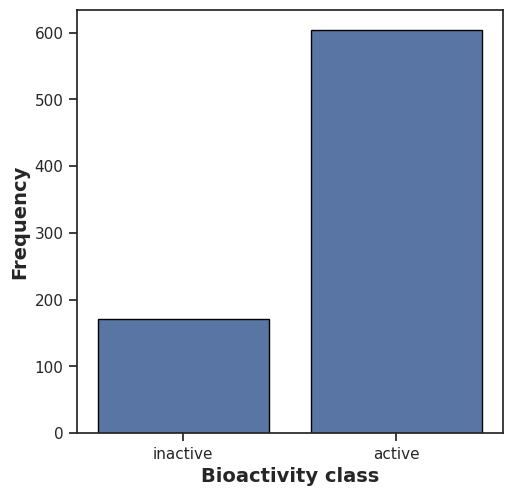

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_combined, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### Scatter plot MW vs LogP

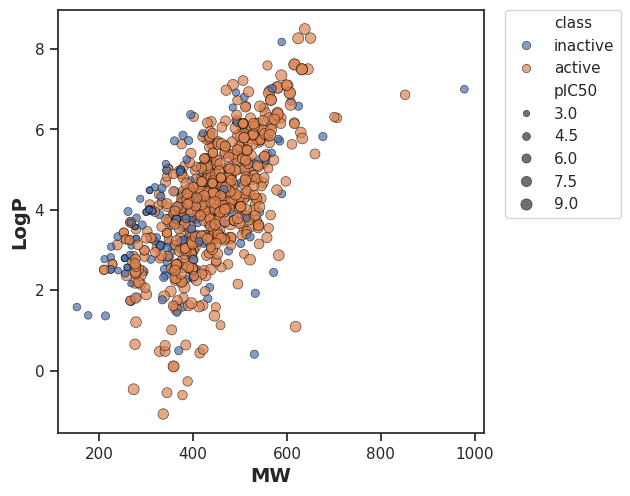

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df2, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### pIC50 Value Boxplots

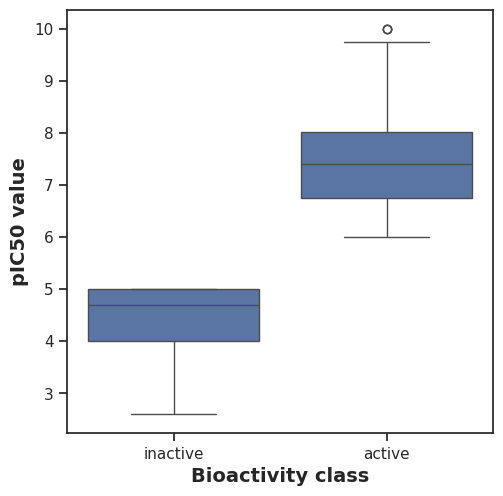

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

### **Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df2[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df2[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,103284.00,0.00,0.05,Different distribution (reject H0)


tolak h0 artinya ada perbedaan antara 2 data tersebut

### MW

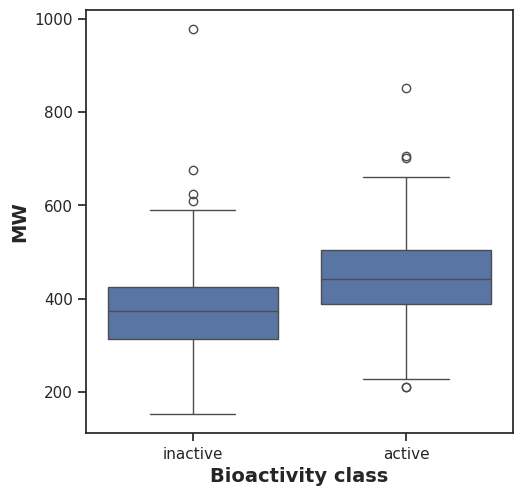

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,72954.50,0.00,0.05,Different distribution (reject H0)


### LogP

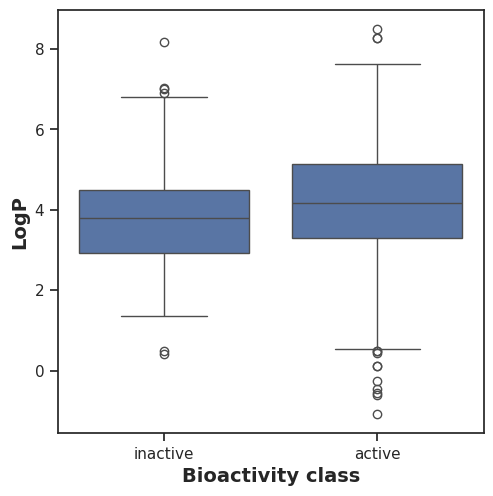

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,61570.50,0.00,0.05,Different distribution (reject H0)


### NumHDonors

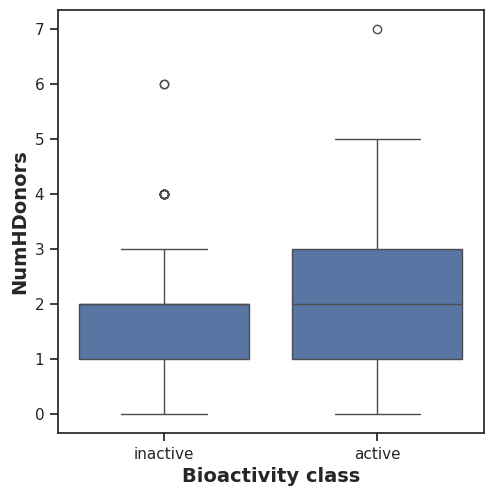

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,62013.50,0.00,0.05,Different distribution (reject H0)


### NumHAcceptors

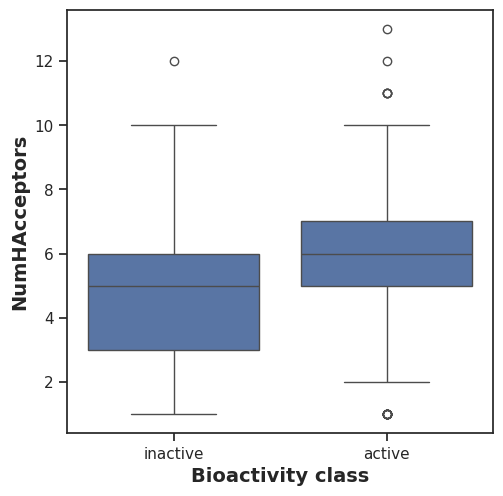

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df2)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,69258.50,0.00,0.05,Different distribution (reject H0)
